# Deepfake detection using GAN


In [517]:
# Imports
import numpy as np
import torch
import torchvision as tv
from tqdm import tqdm
import math
import pandas as pd

import seaborn as sns
import matplotlib


In [518]:
# Configure plots
matplotlib.style.use("seaborn-poster")  # Poster = big, paper = small
matplotlib.style.use("ggplot")
matplotlib.rcParams["font.family"] = "serif"
sns.set_context("poster")  # Poster = big, paper = small


In [519]:
# Paths
train_set = "train_set_frames/"
test_set = "test_set_frames/"


In [520]:
image_size = 64

In [521]:
transform = tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [522]:
# Load the dataset
dataset = tv.datasets.ImageFolder(
    root=train_set + "real",
    transform=transform,
)

# Use dataloader to get batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


In [523]:
# Variables for discriminator and generator
nz = 100 # Size of input vector
ndf = 64 # Size of feature map in discriminator
ngf = 64 # Size of feature map in generator

In [524]:
# Weights for the discriminator and generator
def init_weights(m):
    if type(m) == (torch.nn.ConvTranspose2d or torch.nn.Conv2d):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif type(m) == torch.nn.BatchNorm2d:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


In [525]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()        
        if image_size >= 128:
            self.main = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
                torch.nn.BatchNorm2d(ngf * 16),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf * 8),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf * 4),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf * 2),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
                torch.nn.Tanh()
            )
        else:
            self.main = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
                torch.nn.BatchNorm2d(ngf * 8),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf * 4),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf * 2),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ngf),
                torch.nn.ReLU(True),

                torch.nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
                torch.nn.Tanh()
            )
        self.apply(init_weights)

    def forward(self, input):
        return self.main(input)


In [526]:
# Create the generator
net_gen = Generator()


In [527]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        if image_size >= 128:
            self.main = torch.nn.Sequential(
                torch.nn.Conv2d(3, ndf, 4, 2, 1, bias=False), 
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 2),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 4),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 8),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 16),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
                torch.nn.Sigmoid()
            )
        else:
            self.main = torch.nn.Sequential(
                torch.nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 2),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 4),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
                torch.nn.BatchNorm2d(ndf * 8),
                torch.nn.LeakyReLU(0.2, inplace=True),

                torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
                torch.nn.Sigmoid()
            )
        self.apply(init_weights)

    def forward(self, input):
        return self.main(input)


In [528]:
# Create the Discriminator
net_disc = Discriminator()


In [529]:
# Loss function
loss_fn = torch.nn.BCELoss()

# Optiomisers
net_disc.optimiser = torch.optim.Adam(net_disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
net_gen.optimiser = torch.optim.Adam(net_gen.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [530]:
losses_disc = []
losses_gen = []

for epoch in range(1):
    for i, batch in enumerate(tqdm(dataloader)):
        ## Train with real images through discriminator

        # Set gradient to 0
        net_disc.zero_grad()

        batch = batch[0]

        # Get tensor with labels for real images
        size = batch.size(0)
        label = torch.full((size,), 1.0)

        # Forward pass batch through discriminator
        output = net_disc(batch).view(-1)

        # Calculate loss on batch
        loss_disc_real = loss_fn(output, label)

        # Backwards pass batch through discriminator
        loss_disc_real.backward()

        ## Train with fake images
        # Fake batch
        batch = torch.randn(size, nz, 1, 1)
        
        # Forward pass fake batch through generator
        fake = net_gen(batch)

        # Forward pass fake output through discriminator
        output = net_disc(fake.detach()).view(-1)
        
        # Calculate discriminator loss on batch
        label -= 1
        loss_disc_fake = loss_fn(output, label)

        # Backwards pass batch through discriminator
        loss_disc_fake.backward()

        # Total loss
        loss_disc = loss_disc_real + loss_disc_fake

        # Update discriminator
        net_disc.optimiser.step()

        ## Train with fake images through generator
        # Set gradient to 0
        net_gen.zero_grad()
        
        # Forward pass batch through the updated discriminator.
        output = net_disc(fake).view(-1)

        # Calculate loss on batch
        label += 1
        loss_gen = loss_fn(output, label)

        # Backwards pass batch through generator
        loss_gen.backward()

        # Update generator
        net_gen.optimiser.step()

        # Save losses for plotting later
        losses_disc.append(loss_disc.item())
        losses_gen.append(loss_gen.item())



100%|██████████| 1831/1831 [19:56<00:00,  1.53it/s]


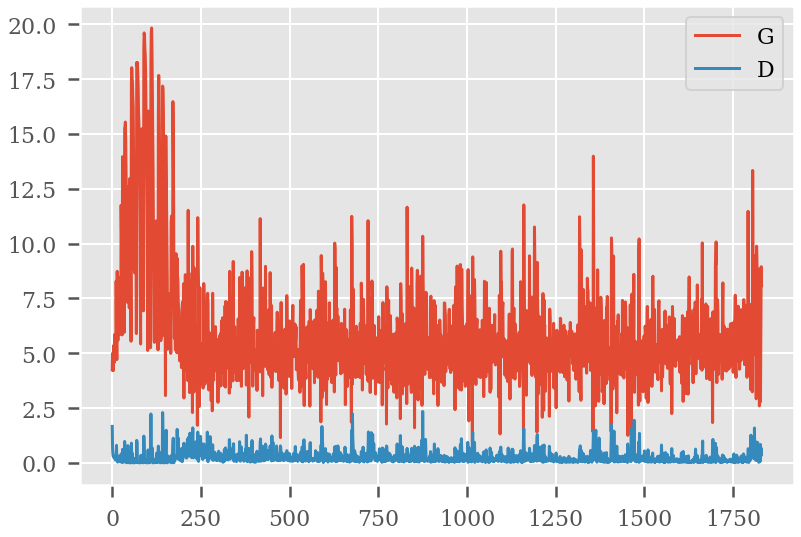

In [531]:
sns.lineplot(x=range(len(losses_gen)), y=losses_gen, label="G")
sns.lineplot(x=range(len(losses_disc)), y=losses_disc, label="D");


# Evaluation

In [532]:
net_disc.eval();


In [533]:
def predict_folder(path):
    """
    Function that predicts the labels of all the images in a folder.
    """
    total = {}
    videos = tv.datasets.ImageFolder(
        root=path,
        transform=transform,
    )

    for ind, val in tqdm(videos.class_to_idx.items()):
        low = math.inf
        high = -1
        for i, ele in enumerate(videos.imgs):
            _, idx = ele
            if idx == val:
                if i < low:
                    low = i
                if i > high:
                    high = i
        high += 1
        video = torch.utils.data.Subset(videos, range(low, high))
        results = {}
        frame_names = videos.imgs[low:high]
        frame_names = [name[0] for name in frame_names]
        name_iter = iter(frame_names)
        with torch.no_grad():
            for i, frame in enumerate(video):
                frame_name = next(name_iter)
                frame = frame[0]
                frame = frame.view(1, *frame.shape)
                pred = net_disc(frame).item()
                if (
                    i != 0 and "face" in frame_name and not "face0" in frame_name
                ):  # If the face is part of a frame with multiple faces, always select the one most likely to be fake.
                    frame_name = list(results.keys())[-1]
                    results[frame_name] = (
                        pred if pred < results[frame_name] else results[frame_name]
                    )
                else:
                    results[frame_name] = pred
        values = list(results.values())
        total[ind] = round(
            np.mean(values)
        )  # Classify the video as fake or real based on the majority of the frames.
    return total


## Check performance on the training set.

In [534]:
train_real = predict_folder(train_set + "real")

100%|██████████| 61/61 [02:45<00:00,  2.72s/it]


In [535]:
df_real = pd.DataFrame(train_real.values(), train_real.keys())

print(f"Correctly classified videos: {df_real[0].sum()}")
print(f"Incorrectly classified videos: {len(df_real.index) - df_real[0].sum()}")
print(
    f"Percentage corretly classified: {round((df_real[0].sum() / len(df_real.index)) * 100, 2)}%"
)

Correctly classified videos: 35
Incorrectly classified videos: 26
Percentage corretly classified: 57.38%


In [536]:
train_fake = predict_folder(train_set + "fake")


100%|██████████| 256/256 [17:44<00:00,  4.16s/it]


In [537]:
df_fake = pd.DataFrame(train_fake.values(), train_fake.keys())

print(f"Correctly classified videos: {len(df_fake) - df_fake[0].sum()}")
print(f"Incorrectly classified videos: {df_fake[0].sum()}")
print(
    f"Percentage corretly classified: {round(((len(df_fake) - df_fake[0].sum()) / len(df_fake)) * 100, 2)}%"
)


Correctly classified videos: 181
Incorrectly classified videos: 75
Percentage corretly classified: 70.7%


## Check performance on the test set.

In [538]:
total_real = predict_folder(test_set + "real")


100%|██████████| 14/14 [01:06<00:00,  4.76s/it]


In [539]:
df_real = pd.DataFrame(total_real.values(), total_real.keys())

print(f"Correctly classified videos: {df_real[0].sum()}")
print(f"Incorrectly classified videos: {len(df_real.index) - df_real[0].sum()}")
print(
    f"Percentage corretly classified: {round((df_real[0].sum() / len(df_real.index)) * 100, 2)}%"
)


Correctly classified videos: 0
Incorrectly classified videos: 14
Percentage corretly classified: 0.0%


In [540]:
total_fake = predict_folder(test_set + "fake")


100%|██████████| 86/86 [05:58<00:00,  4.17s/it]


In [541]:
df_fake = pd.DataFrame(total_fake.values(), total_fake.keys())

print(f"Correctly classified videos: {len(df_fake) - df_fake[0].sum()}")
print(f"Incorrectly classified videos: {df_fake[0].sum()}")
print(
    f"Percentage corretly classified: {round(((len(df_fake) - df_fake[0].sum()) / len(df_fake)) * 100, 2)}%"
)


Correctly classified videos: 86
Incorrectly classified videos: 0
Percentage corretly classified: 100.0%
